# Analysis of DNA binding mutants 

In [293]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystan
import glob
import bokeh.io
import bokeh.plotting
import bokeh.palettes
import sys
sys.path.insert(0, '../../')
import mut.bayes
import mut.viz
import mut.stats
import mut.thermo
bokeh.io.output_notebook()
colors = mut.viz.pub_style()
%matplotlib inline

Loading BokehJS ...

In [294]:
# Load all of the 2018 flow data.
flow_files = glob.glob('../processing/2018*flow*/output/*fold_change.csv')
dfs = [pd.read_csv(f, comment='#') for f in flow_files]
flow_data = pd.concat(dfs, axis=0)

# Load the microscopy data
mic_files = glob.glob('../processing/2018*microscopy*/output/*fold_change.csv')
dfs = [pd.read_csv(f) for f in mic_files]
mic_data = pd.concat(dfs, axis=0)

In [295]:
# Isolate the leakiness data
leakiness = flow_data[(flow_data['IPTGuM'] ==0) & (flow_data['mutant'] != 'Q21M') &
                     (flow_data['mutant'] != 'wt') & (flow_data['mutant'] != 'auto') 
                     & (flow_data['mutant'] != 'delta') & (flow_data['mutant'] != np.nan) &
                     (flow_data['mutant'] != 'Q294K') & (flow_data['mutant'] != 'Q294V') &
                     (flow_data['mutant'] != 'F164T')].copy()
leakiness.drop('Unnamed: 0', axis=1, inplace=True)
leakiness.rename(columns={'mean_FITC_H':'mean_intensity'}, inplace=True)
leakiness.loc[:, 'method'] = 'flow'
mic_data.loc[:, 'method'] = 'microscopy'
merged = pd.concat([leakiness, mic_data], ignore_index=True)
merged = merged[(merged['mutant'] != 'none')]

In [296]:
# Plot the data points. 
p1 = bokeh.plotting.figure(x_axis_label='repressor copy number',
                          y_axis_label='fold-change',
                          x_axis_type='log', y_axis_type='log',
                          plot_width=600, plot_height=400)

grouped = merged.groupby(['mutant'])
colors = bokeh.palettes.Accent8
i = 0
for g, d in grouped:
    _grouped = d.groupby('repressors')
    for _g, _d in _grouped:
        _d = _d.mean()
        p1.circle(_d['repressors'], _d['fold_change'], legend=g,
                     color=colors[i])
    i += 1
bokeh.io.show(p1)


In [297]:
# Include IDs for heirarchical model.
merged.loc[:, 'id'] = 1
merged.loc[merged['mutant'] == 'Q21A', 'id'] = 2
merged.loc[merged['mutant'] == 'Q21M', 'id'] = 3

In [298]:
def assemble_StanModelCode(model_file, function_file):
    """Returns a string of the stan model code from a model and function file"""
    lines = []
    files = [function_file, model_file]
    for f in files:
        with open(f, 'r') as file:
            out = file.read().splitlines()
            for line in out:
                lines.append(line) 
    model_code = """\n"""
    for line in lines:
        model_code += line + '\n'
    return model_code

In [299]:
model_code = assemble_StanModelCode('../stan/heirarchical_epR_fit.stan', '../stan/functions.stan')
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_31d86c808853debbc6ac3a765ef665db NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpmdrce97a/stanfit4anon_model_31d86c808853debbc6ac3a765ef665db_615529716016756056.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpmdrce97a/stanfit4anon_model_31d86c808853debbc6ac3a765ef665db_615529716016756056.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::__1

In [311]:
merged = merged[(merged['fold_change'] >= -0.2) & (merged['fold_change'] <= 1.3)]
# Assemble the data dictionary. 
ka = 139
ki = 0.53
data_dict = {'J':3, 'N':len(merged), 'trial':merged['id'].values,
            'R':merged['repressors'].values, 'n_ns':4.6E6, 'ka':-np.log(ka), 'ki':-np.log(ki),
            'ep_AI':4.5, 'n_sites':2, 'c':np.zeros(len(merged)), 'fc':merged['fold_change'].values}

# Sample the distribution.
samples = sm.sampling(data=data_dict, iter=5000, chains=4)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [312]:
samples

Inference for Stan model: anon_model_31d86c808853debbc6ac3a765ef665db.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ep_R[0]   -9.68  1.2e-3   0.12  -9.92  -9.76  -9.68   -9.6  -9.44  10000    1.0
ep_R[1]  -10.28  9.7e-4    0.1 -10.47 -10.34 -10.28 -10.22 -10.09  10000    1.0
ep_R[2]  -15.12  9.5e-4   0.07 -15.26 -15.16 -15.12 -15.08  -15.0   4936    1.0
sigma[0]   0.12  1.9e-4   0.02   0.09   0.11   0.12   0.13   0.16  10000    1.0
sigma[1]   0.09  1.6e-4   0.02   0.07   0.08   0.09    0.1   0.13  10000    1.0
sigma[2] 2.0e-3  1.2e-5 7.8e-4 1.1e-3 1.5e-3 1.8e-3 2.2e-3 3.8e-3   4442    nan
lp__     112.26    0.03   1.91  107.7 111.23 112.62 113.67 114.87   3662    1.0

Samples were drawn using NUTS at Wed Apr  4 20:54:36 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reducti

In [313]:
def chains_to_dataframe(fit):
    data = fit.extract()
    keys = list(data.keys())
    varnames = [k for k in keys if 'lp__' not in k]
    samples = {}
    for i, key in enumerate(varnames):
        # Get the shape.
        dim = np.shape(data[key])
        if len(dim) == 2:
            for j in range(dim[-1]):
                samples['{}.{}'.format(key, j+1)] = data[key][:, j]
    
        else:
            samples[key] = data[key]
            
    # compute the log_post. 
    new_keys = samples.keys()
    logp = []
    for j in range(dim[0]):
        logp.append(fit.log_prob([samples[k][j] for k in fit.unconstrained_param_names()]))
        
    samples['logp'] = logp
    return pd.DataFrame(samples)
    

In [314]:
df = chains_to_dataframe(samples)

df.rename(columns={'ep_R.1':'epR_Y20I', 'ep_R.2':'epR_Q21A', 'ep_R.3':'epR_Q21M'},
         inplace=True)

In [315]:
stats = mut.stats.compute_statistics(df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [316]:
stats

,parameter,mode,hpd_min,hpd_max
0,epR_Y20I,-9.755671,-9.909604,-9.430528
1,epR_Q21A,-10.244698,-10.474886,-10.094887
2,epR_Q21M,-15.123096,-15.254451,-14.999804
3,sigma.1,0.082917,0.085166,0.157842
4,sigma.2,0.060397,0.065312,0.125929
5,sigma.3,0.001567,0.000930,0.003304


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


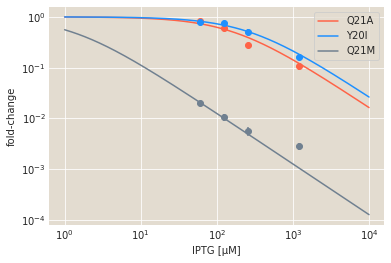

In [318]:
# Plot the fits. 
rep_range = np.logspace(0, 4, 500)
muts = merged['mutant'].unique()
ep_R = [stats[stats['parameter']=='epR_{}'.format(m)]['mode'].values[0] for m in muts]
meshed_R, meshed_ep = np.meshgrid(rep_range, ep_R)
arch = mut.thermo.SimpleRepression(R=meshed_R, ep_r=meshed_ep, ep_ai=4.5, ka=139, ki=0.53,
                                  n_sites=int(2), n_ns=4.6E6, effector_conc=0)
fc = arch.fold_change()

fig, ax = plt.subplots(1,1, figsize=(6, 4))    
ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')
ax.set_yscale('log')
ax.set_xscale('log')
colors = ['tomato', 'dodgerblue', 'slategray']
color_dict = {i: j for i, j in zip(muts, colors)}
for i in range(3):
    _  = ax.plot(rep_range, fc[i, :], '-', color=colors[i],
                  label=muts[i])
ax.legend()
grouped = merged.groupby(['mutant', 'repressors'])
i = 0
for g, d in grouped:
    _ = ax.errorbar(g[1], d['fold_change'].mean(), d['fold_change'].std() / np.sqrt(len(d)),
                   color=color_dict[g[0]], linestyle='none', fmt='o')
